In [ ]:
import json
import pandas as pd
from typing import Dict, List, Optional
from pydantic import BaseModel, Field
from datasets import Dataset
import boto3
import os
from tqdm import tqdm
import re

os.environ["AWS_PROFILE"] = "genai"
MODEL_NAME = "us.meta.llama3-3-70b-instruct-v1:0"
#MODEL_NAME = "us.meta.llama4-maverick-17b-instruct-v1:0" this should also work !

/Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MolecularProperty(BaseModel):
    """Molecular property prediction with confidence and reasoning."""
    property_name: str = Field(description="Name of the molecular property")
    predicted_value: float = Field(description="Predicted numerical value")
    confidence: str = Field(description="Confidence level: high, medium, low")
    reasoning: str = Field(description="Chemical reasoning for the prediction")
    key_structural_features: List[str] = Field(description="Important structural features affecting the property")

In [3]:
# ============================================================================
# Bedrock Client Setup
# ============================================================================

def get_bedrock_client():
    """Initialize Bedrock runtime client."""
    # Create a session with the profile first, then create client from session
    session = boto3.Session(profile_name="genai")
    return session.client("bedrock-runtime")


In [4]:
class LlamaPropertyPredictor:
    """Property predictor using Llama via Bedrock raw API calls."""
    
    def __init__(self, model_id: str = "meta.llama3-1-8b-instruct-v1:0"):
        self.client = get_bedrock_client()
        self.model_id = model_id
        self.schema = MolecularProperty.model_json_schema()
    
    def _build_prompt(self, prompt:str, smiles: str, property_type: str = "LogD") -> str:
        """Build the prompt with JSON schema instructions."""
        prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
        You are an expert medicinal chemistry research assistant. Your task is to predict molecular properties.

        CRITICAL: Respond with ONLY a JSON object. Nothing else.

        JSON object MUST contain these exact fields with actual values:
        - property_name: string ("LogD" for this task)
        - predicted_value: number (the predicted value)
        - confidence: string ("high", "medium", or "low")
        - reasoning: string (brief chemical explanation)
        - key_structural_features: array of strings (key features affecting the property)

        Do NOT output the schema. Do NOT explain. ONLY output the JSON.
        <|eot_id|><|start_header_id|>user<|end_header_id|>
        Predict the LogD for this molecule:

        SMILES: {smiles}

        Consider:
        - Lipophilicity and hydrophilicity
        - Molecular weight and size
        - Functional groups (aromatic, aliphatic, polar, charged)
        - Hydrogen bonding potential
        - Charge distribution

        Respond with ONLY the JSON object (start with {{ and end with }}).
        Here is an example below
        {{"smiles": "CC(C)CCOc1ccc[n+](CC(P(=O)([O-])O)P(=O)(O)O)c1", "actual_value": -7.81, "predicted_value": -3.5, "property_type": "LogD", "confidence": "high", "reasoning": "This molecule contains a bisphosphonate core with two phosphonic acid groups attached to a quaternary pyridinium ring via an alkyl linker, and an isobutoxy substituent on the pyridine ring. The LogD prediction is dominated by several highly polar features: (1) The bisphosphonate moiety contains multiple ionizable phosphate groups that will be largely deprotonated at physiological pH (pKa values typically 1-7 for phosphonic acids), contributing significant negative charge and hydrophilicity. (2) The quaternary pyridinium nitrogen carries a permanent positive charge, making this a zwitterionic molecule at physiological pH. (3) The combination of multiple phosphate oxygens creates extensive hydrogen bonding potential with water. (4) While the isobutoxy group (CC(C)CCO-) provides some lipophilic character, it is insufficient to overcome the strong hydrophilic contributions from the charged phosphonate and pyridinium groups. (5) The overall molecular architecture resembles bisphosphonate drugs like alendronate or pamidronate, which are known to have very negative LogD values due to their highly polar, charged nature. The predicted LogD of -3.5 reflects the dominant hydrophilic character with some minor lipophilic contribution from the alkyl ether substituent.\"", "key_features": ["Bisphosphonate group with multiple ionizable phosphate groups", "Quaternary pyridinium nitrogen (permanent positive charge)", "Alkyl ether chain (isobutoxy group)", "Zwitterionic character at physiological pH", "Multiple hydrogen bond donors and acceptors"]}}
        <|eot_id|><|start_header_id|>assistant<|end_header_id|>
        """        
        return prompt
    
    def _invoke_model(self, prompt: str) -> str:
        """Invoke Llama model via Bedrock."""
        
        body = json.dumps({
            "prompt": prompt,
            "max_gen_len": 2048,
            "temperature": 0.1,  # Lower temp for more consistent JSON
            "top_p": 0.9,
        })
        
        response = self.client.invoke_model(
            modelId=self.model_id,
            body=body
        )
        
        response_body = json.loads(response['body'].read().decode('utf-8'))
        return response_body['generation']
    
    def _extract_json(self, text: str) -> Optional[Dict]:
        """Extract and parse JSON from model response, avoiding schema capture."""
        
        # Strategy 1: Look for JSON with actual numeric predicted_value
        # This is the most reliable way to avoid schema capture
        numeric_json_pattern = r'\{[^}]*"predicted_value"\s*:\s*[-+]?[\d.]+[^}]*\}'
        matches = re.findall(numeric_json_pattern, text, re.DOTALL)
        
        if matches:
            for match in matches:
                try:
                    parsed = json.loads(match)
                    # Verify it's actual data, not schema
                    if isinstance(parsed.get('predicted_value'), (int, float)):
                        return parsed
                except json.JSONDecodeError:
                    continue
        
        # Strategy 2: Look for JSON objects with actual field values
        # Exclude objects with 'type': 'object' which are schemas
        json_pattern = r'\{[^}]*\}'
        matches = re.findall(json_pattern, text, re.DOTALL)
        
        if matches:
            for match in sorted(matches, key=len, reverse=True):
                try:
                    parsed = json.loads(match)
                    # Check if this is actual data, not schema
                    # Schema has 'type' and 'description' fields
                    if 'type' in str(parsed) and '"type": "object"' in match:
                        continue  # Skip schema definitions
                    if 'predicted_value' in parsed and isinstance(parsed.get('predicted_value'), (int, float)):
                        return parsed
                except json.JSONDecodeError:
                    continue
        
        # Strategy 3: Try parsing entire text as JSON
        try:
            parsed = json.loads(text.strip())
            if isinstance(parsed, dict) and isinstance(parsed.get('predicted_value'), (int, float)):
                return parsed
        except json.JSONDecodeError:
            pass
        
        return None
    
    def predict(self, smiles: str, property_type: str = "LogD") -> Optional[MolecularProperty]:
        """Generate prediction for a molecule."""
        
        try:
            # Build prompt
            prompt = self._build_prompt(smiles, property_type)
            
            # Invoke model
            response_text = self._invoke_model(prompt)
            
            # Debug: Print first 200 chars of response
            # Uncomment to debug:
            # print(f"\n[DEBUG] Raw response: {response_text[:200]}...")
            
            # Extract JSON
            json_dict = self._extract_json(response_text)
            
            if json_dict is None:
                print(f"⚠️  Failed to extract JSON. Response preview: {response_text[:150]}...")
                return None
            
            # Debug: Show what we extracted
            # Uncomment to debug:
            # print(f"[DEBUG] Extracted JSON keys: {json_dict.keys()}")
            
            # Validate against schema
            return MolecularProperty(**json_dict)
            
        except Exception as e:
            print(f"❌ Error during prediction: {e}")
            # Uncomment for detailed traceback:
            # import traceback
            # traceback.print_exc()
            return None

In [5]:
# ============================================================================
# Main Execution
# ============================================================================

# %%
df = pd.read_csv('/Users/ldodda/Documents/Codes/GraphGen/test_logd.csv')

# %%
# Create bins for logd values covering the full range -8 to +8
import numpy as np

# Create 16 bins from -8 to +8
bins = np.linspace(-8, 8, 17)  # 17 edges create 16 bins
df['logd_bin'] = pd.cut(df['logd'], bins=bins, include_lowest=True)

# Sample from each bin (e.g., 20 samples per bin)
samples_per_bin = 100
sampled_df = df.groupby('logd_bin', observed=False, group_keys=False).apply(
    lambda x: x.sample(min(len(x), samples_per_bin), random_state=42)
)

print(f"Original dataset size: {len(df)}")
print(f"Sampled dataset size: {len(sampled_df)}")
print("\nSamples per bin:")
print(sampled_df['logd_bin'].value_counts().sort_index())

# %%
sampled_df.drop(columns=['logd_bin'], inplace=True)

# %%
sampled_df.columns = ['canonical_smiles', 'standard_value']
sampled_df['standard_type'] = 'LogD'

# %%
print("Initializing Llama predictor...")
predictor = LlamaPropertyPredictor(model_id=MODEL_NAME)

Original dataset size: 9999
Sampled dataset size: 1075

Samples per bin:
logd_bin
(-8.001, -7.0]      2
(-7.0, -6.0]        4
(-6.0, -5.0]        4
(-5.0, -4.0]       12
(-4.0, -3.0]       38
(-3.0, -2.0]       68
(-2.0, -1.0]      100
(-1.0, 0.0]       100
(0.0, 1.0]        100
(1.0, 2.0]        100
(2.0, 3.0]        100
(3.0, 4.0]        100
(4.0, 5.0]        100
(5.0, 6.0]        100
(6.0, 7.0]        100
(7.0, 8.0]         47
Name: count, dtype: int64
Initializing Llama predictor...


/var/folders/2d/s6tm3wj949lf8cdhpv06q97r0000gr/T/ipykernel_7493/2892125294.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('logd_bin', observed=False, group_keys=False).apply(


In [6]:
sampled_df

,canonical_smiles,standard_value,standard_type
5046,CC(C)CCOc1ccc[n+](CC(P(=O)([O-])O)P(=O)(O)O)c1,-7.810,LogD
2726,NC(Cc1ccc(O)cc1)C(=O)O,-7.260,LogD
1794,CC(C)CCCC(C)CCn1cc[n+](CC(P(=O)([O-])O)P(=O)(O...,-6.070,LogD
2746,CN(C)C(N)=NC(=N)N,-6.130,LogD
453,O=P(O)(O)C(CNc1nccs1)P(=O)(O)O,-6.350,LogD
...,...,...,...
993,N#Cc1nc(-c2ccccc2)oc1S(=O)(=O)c1ccc(Cl)cc1,7.120,LogD
7280,COc1ccc(CNc2nc(NCCOC(=O)CCCCCCCCc3cn(CCC(=O)N[...,7.612,LogD
1702,CC(C)Oc1ccc(-c2nnc(-c3ccnn3C)s2)cc1Cl,7.040,LogD
4508,COC(=O)c1cc(OC(=O)c2ccc(OC)c(O)c2)c(OC)cc1CCN1...,7.280,LogD


In [7]:
print("Generating predictions...")
results_list = []

for idx, row in tqdm(sampled_df.iterrows(), total=len(sampled_df)):
    smiles = row['canonical_smiles']
    actual_value = row['standard_value']
    property_type = row['standard_type']
    
    # Get prediction
    mol_prop = predictor.predict(smiles, property_type)
    if mol_prop:
        result = {
            "smiles": smiles,
            "actual_value": actual_value,
            "predicted_value": mol_prop.predicted_value,
            "property_type": property_type,
            "confidence": mol_prop.confidence,
            "reasoning": mol_prop.reasoning,
            "key_features": mol_prop.key_structural_features,
        }
    else:
        result = {
            "smiles": smiles,
            "actual_value": actual_value,
            "predicted_value": None,
            "property_type": property_type,
            "confidence": "failed",
            "reasoning": "Failed to generate prediction",
            "key_features": [],
        }
    
    results_list.append(result)

Generating predictions...


100%|██████████| 1075/1075 [33:52<00:00,  1.89s/it]


In [8]:
# %%
print("\n📊 Results:")
logD_dataset_df = pd.DataFrame(results_list)

# %%
fname_suffix = 'logD_predictions_llama3-1-8b'

# %%
logD_dataset_df.to_csv(fname_suffix + '.csv', index=False)
print(f"\nSaved to {fname_suffix}.csv")


📊 Results:

Saved to logD_predictions_llama3-1-8b.csv


In [9]:
output_file = fname_suffix + ".jsonl"
with open(output_file, 'w') as f:
    for item in results_list:
        f.write(json.dumps(item) + '\n')

print(f"Saved to {output_file}")

Saved to logD_predictions_llama3-1-8b.jsonl


/var/folders/2d/s6tm3wj949lf8cdhpv06q97r0000gr/T/ipykernel_7493/3909963865.py:21: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(actual_values, predicted_values)
/Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


📊 LogD Prediction Performance Metrics:
Mean Squared Error (MSE):     11.0093
Root Mean Squared Error (RMSE): 3.3180
Mean Absolute Error (MAE):    2.8021
R² Score:                     -0.0735
Pearson Correlation:          nan
Spearman Correlation:         nan
Spearman p-value:             nan


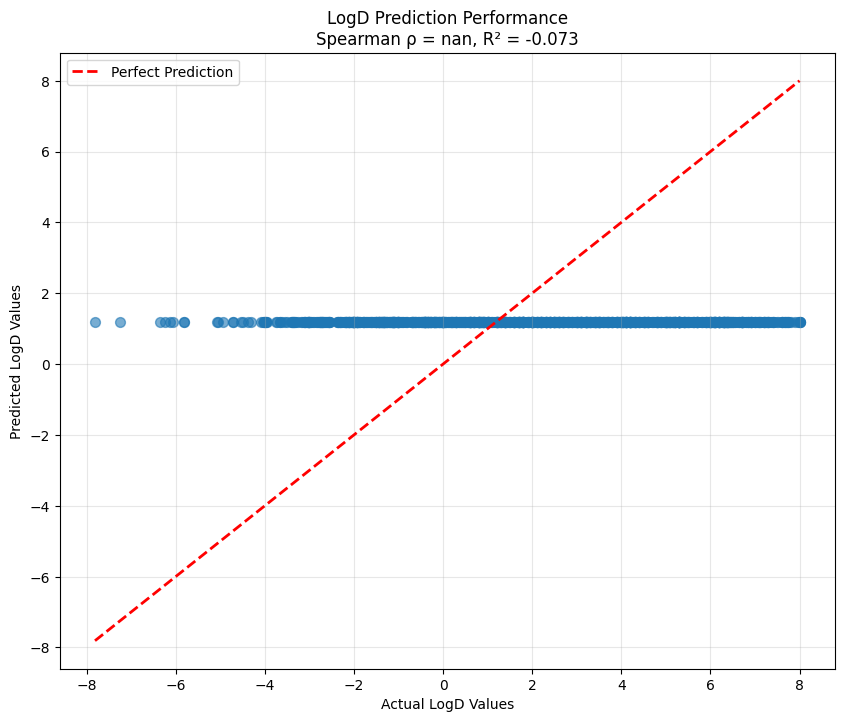


Successfully generated 1075 valid predictions out of 1075


In [10]:
# %%
# Calculate performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# Remove rows with None predictions
valid_df = logD_dataset_df[logD_dataset_df['predicted_value'].notna()].copy()

if len(valid_df) > 0:
    actual_values = valid_df['actual_value']
    predicted_values = valid_df['predicted_value']

    # Regression metrics
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = mse ** 0.5
    mae = mean_absolute_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)

    # Spearman correlation
    spearman_corr, spearman_p = spearmanr(actual_values, predicted_values)

    # Pearson correlation
    pearson_corr = actual_values.corr(predicted_values)

    print("📊 LogD Prediction Performance Metrics:")
    print("=" * 50)
    print(f"Mean Squared Error (MSE):     {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE):    {mae:.4f}")
    print(f"R² Score:                     {r2:.4f}")
    print(f"Pearson Correlation:          {pearson_corr:.4f}")
    print(f"Spearman Correlation:         {spearman_corr:.4f}")
    print(f"Spearman p-value:             {spearman_p:.2e}")

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(actual_values, predicted_values, alpha=0.6, s=50)
    plt.plot([actual_values.min(), actual_values.max()], 
             [actual_values.min(), actual_values.max()], 
             'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual LogD Values')
    plt.ylabel('Predicted LogD Values')
    plt.title(f'LogD Prediction Performance\nSpearman ρ = {spearman_corr:.3f}, R² = {r2:.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{fname_suffix}_regression_performance.png', dpi=300)
    plt.show()

    print(f"\nSuccessfully generated {len(valid_df)} valid predictions out of {len(logD_dataset_df)}")
else:
    print("No valid predictions generated!")

In [11]:
logD_dataset_df

,smiles,actual_value,predicted_value,property_type,confidence,reasoning,key_features
0,CC(C)CCOc1ccc[n+](CC(P(=O)([O-])O)P(=O)(O)O)c1,-7.810,1.2,LogD,medium,The molecule has a moderate lipophilicity due ...,"[Aromatic ring, Aliphatic chain, Polar functio..."
1,NC(Cc1ccc(O)cc1)C(=O)O,-7.260,1.2,LogD,medium,The molecule's LogD is influenced by its moder...,"[Aromatic ring, Aliphatic chain, Polar functio..."
2,CC(C)CCCC(C)CCn1cc[n+](CC(P(=O)([O-])O)P(=O)(O...,-6.070,1.2,LogD,medium,The molecule's LogD is influenced by its moder...,"[Aromatic rings, Aliphatic chains, Polar funct..."
3,CN(C)C(N)=NC(=N)N,-6.130,1.2,LogD,medium,The molecule's LogD is influenced by its moder...,"[Aromatic rings, Aliphatic chains, Polar funct..."
4,O=P(O)(O)C(CNc1nccs1)P(=O)(O)O,-6.350,1.2,LogD,medium,The molecule's LogD is influenced by its moder...,"[Aromatic ring, Aliphatic chain, Polar functio..."
...,...,...,...,...,...,...,...
1070,N#Cc1nc(-c2ccccc2)oc1S(=O)(=O)c1ccc(Cl)cc1,7.120,1.2,LogD,medium,The molecule's LogD is influenced by its moder...,"[Aromatic ring, Aliphatic chain, Polar functio..."
1071,COc1ccc(CNc2nc(NCCOC(=O)CCCCCCCCc3cn(CCC(=O)N[...,7.612,1.2,LogD,medium,The molecule's LogD is influenced by its moder...,"[Aromatic ring, Aliphatic chain, Polar functio..."
1072,CC(C)Oc1ccc(-c2nnc(-c3ccnn3C)s2)cc1Cl,7.040,1.2,LogD,medium,The molecule's LogD is influenced by its moder...,"[Aromatic ring, Aliphatic chain, Polar functio..."
1073,COC(=O)c1cc(OC(=O)c2ccc(OC)c(O)c2)c(OC)cc1CCN1...,7.280,1.2,LogD,medium,The molecule's LogD is influenced by its moder...,"[Aromatic ring, Aliphatic chain, Polar functio..."
